In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [104]:
dataset = "https://drive.google.com/uc?export=download&id=11sXDbPQjFdOEL5Nz3ACA0MM3QwaShBfZ"
df = pd.read_csv(dataset, sep="\t")
print(df.shape)

(2240, 29)


In [105]:
print(df.isna().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [106]:
df.dropna(inplace=True) #droping null value
df.drop_duplicates(inplace=True) #droping duplicate values
print(df.shape,"\n\n")
print(df.info())

(2216, 29) 


<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non

In [107]:
df['Churn']= ((df['Response']==0) & (((df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']) < 396) | ((df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']) < 15))).astype(int)

In [108]:
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], errors='coerce')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce', dayfirst=True)
today = pd.Timestamp.today()
df['Age'] = today.year - df['Year_Birth'].astype(int)
df['Tenure'] = (today - df['Dt_Customer']).dt.days / 365
df['Campaigns_Accepted'] = df[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=1)
df['Education'] = df['Education'].replace(['PhD','2n Cycle','Graduation', 'Master'],'PG')
df['Education'] = df['Education'].replace(['Basic'], 'UG')
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'],'Mingle')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['NumTotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']
df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', "Z_CostContact", "Z_Revenue",'MntWines',
                 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
                 'Kidhome', 'Teenhome', 'NumWebVisitsMonth','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
                 'NumDealsPurchases','Response', 'Recency'], axis=1, inplace=True)

print(df.shape)
print(df.info())

(2216, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Education           2216 non-null   object 
 1   Marital_Status      2216 non-null   object 
 2   Income              2216 non-null   float64
 3   Complain            2216 non-null   int64  
 4   Churn               2216 non-null   int64  
 5   Age                 2216 non-null   int64  
 6   Tenure              2216 non-null   float64
 7   Campaigns_Accepted  2216 non-null   int64  
 8   Expenses            2216 non-null   int64  
 9   Kids                2216 non-null   int64  
 10  NumTotalPurchases   2216 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 207.8+ KB
None


In [109]:
df_copy=df.copy()
categorical_cols=['Education', 'Marital_Status']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_copy = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
print(df_copy.head(20))

     Income  Complain  Churn   Age     Tenure  Campaigns_Accepted  Expenses  \
0   58138.0       0.0    0.0  68.0  13.093151                 0.0    1617.0   
1   46344.0       0.0    1.0  71.0  11.586301                 0.0      27.0   
2   71613.0       0.0    0.0  60.0  12.131507                 0.0     776.0   
3   26646.0       0.0    1.0  41.0  11.657534                 0.0      53.0   
4   58293.0       0.0    0.0  44.0  11.717808                 0.0     422.0   
5   62513.0       0.0    0.0  58.0  12.079452                 0.0     716.0   
6   55635.0       0.0    0.0  54.0  12.901370                 0.0     590.0   
7   33454.0       0.0    1.0  40.0  12.419178                 0.0     169.0   
8   30351.0       0.0    0.0  51.0  12.339726                 0.0      46.0   
9    5648.0       0.0    1.0  75.0  11.572603                 1.0      49.0   
11   7500.0       0.0    1.0  49.0  12.901370                 0.0      61.0   
12  63033.0       0.0    0.0  66.0  11.895890       

In [110]:
scaler = StandardScaler()
numerical_features = ['Income', 'Kids', 'Expenses','Campaigns_Accepted', 'NumTotalPurchases', 'Age', 'Tenure','Complain']
df_copy[numerical_features] = scaler.fit_transform(df_copy[numerical_features])
print(df_copy.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2239 entries, 0 to 2084
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 2216 non-null   float64
 1   Complain               2216 non-null   float64
 2   Churn                  2216 non-null   float64
 3   Age                    2216 non-null   float64
 4   Tenure                 2216 non-null   float64
 5   Campaigns_Accepted     2216 non-null   float64
 6   Expenses               2216 non-null   float64
 7   Kids                   2216 non-null   float64
 8   NumTotalPurchases      2216 non-null   float64
 9   Education_UG           2216 non-null   float64
 10  Marital_Status_Single  2216 non-null   float64
dtypes: float64(11)
memory usage: 209.9 KB
None


In [111]:
df_copy.dropna(inplace=True)
print(df_copy.shape)

(2193, 11)


In [112]:
#After Trying Different No. of n_clusters n_clusters = 3 seems best therefore creating 3 clusters....
kmeans=KMeans(n_clusters=3,n_init='auto', random_state=42).fit(df_copy)
pred=kmeans.predict(df_copy)

df_copy['cluster_Kmeans'] = pred + 1

print(df_copy.head())

     Income  Complain  Churn       Age    Tenure  Campaigns_Accepted  \
0  0.234063 -0.097812    0.0  0.986443  1.529129           -0.439265   
1 -0.234559 -0.097812    1.0  1.236801 -1.188411           -0.439265   
2  0.769478 -0.097812    0.0  0.318822 -0.205155           -0.439265   
3 -1.017239 -0.097812    1.0 -1.266777 -1.059945           -0.439265   
4  0.240221 -0.097812    0.0 -1.016420 -0.951244           -0.439265   

   Expenses      Kids  NumTotalPurchases  Education_UG  Marital_Status_Single  \
0  1.675488 -1.264803           1.319446           0.0                    1.0   
1 -0.962358  1.405806          -1.157987           0.0                    1.0   
2  0.280250 -1.264803           0.797881           0.0                    0.0   
3 -0.919224  0.070501          -0.897205           0.0                    0.0   
4 -0.307044  0.070501           0.537099           0.0                    0.0   

   cluster_Kmeans  
0               2  
1               3  
2               2  


<Axes: >

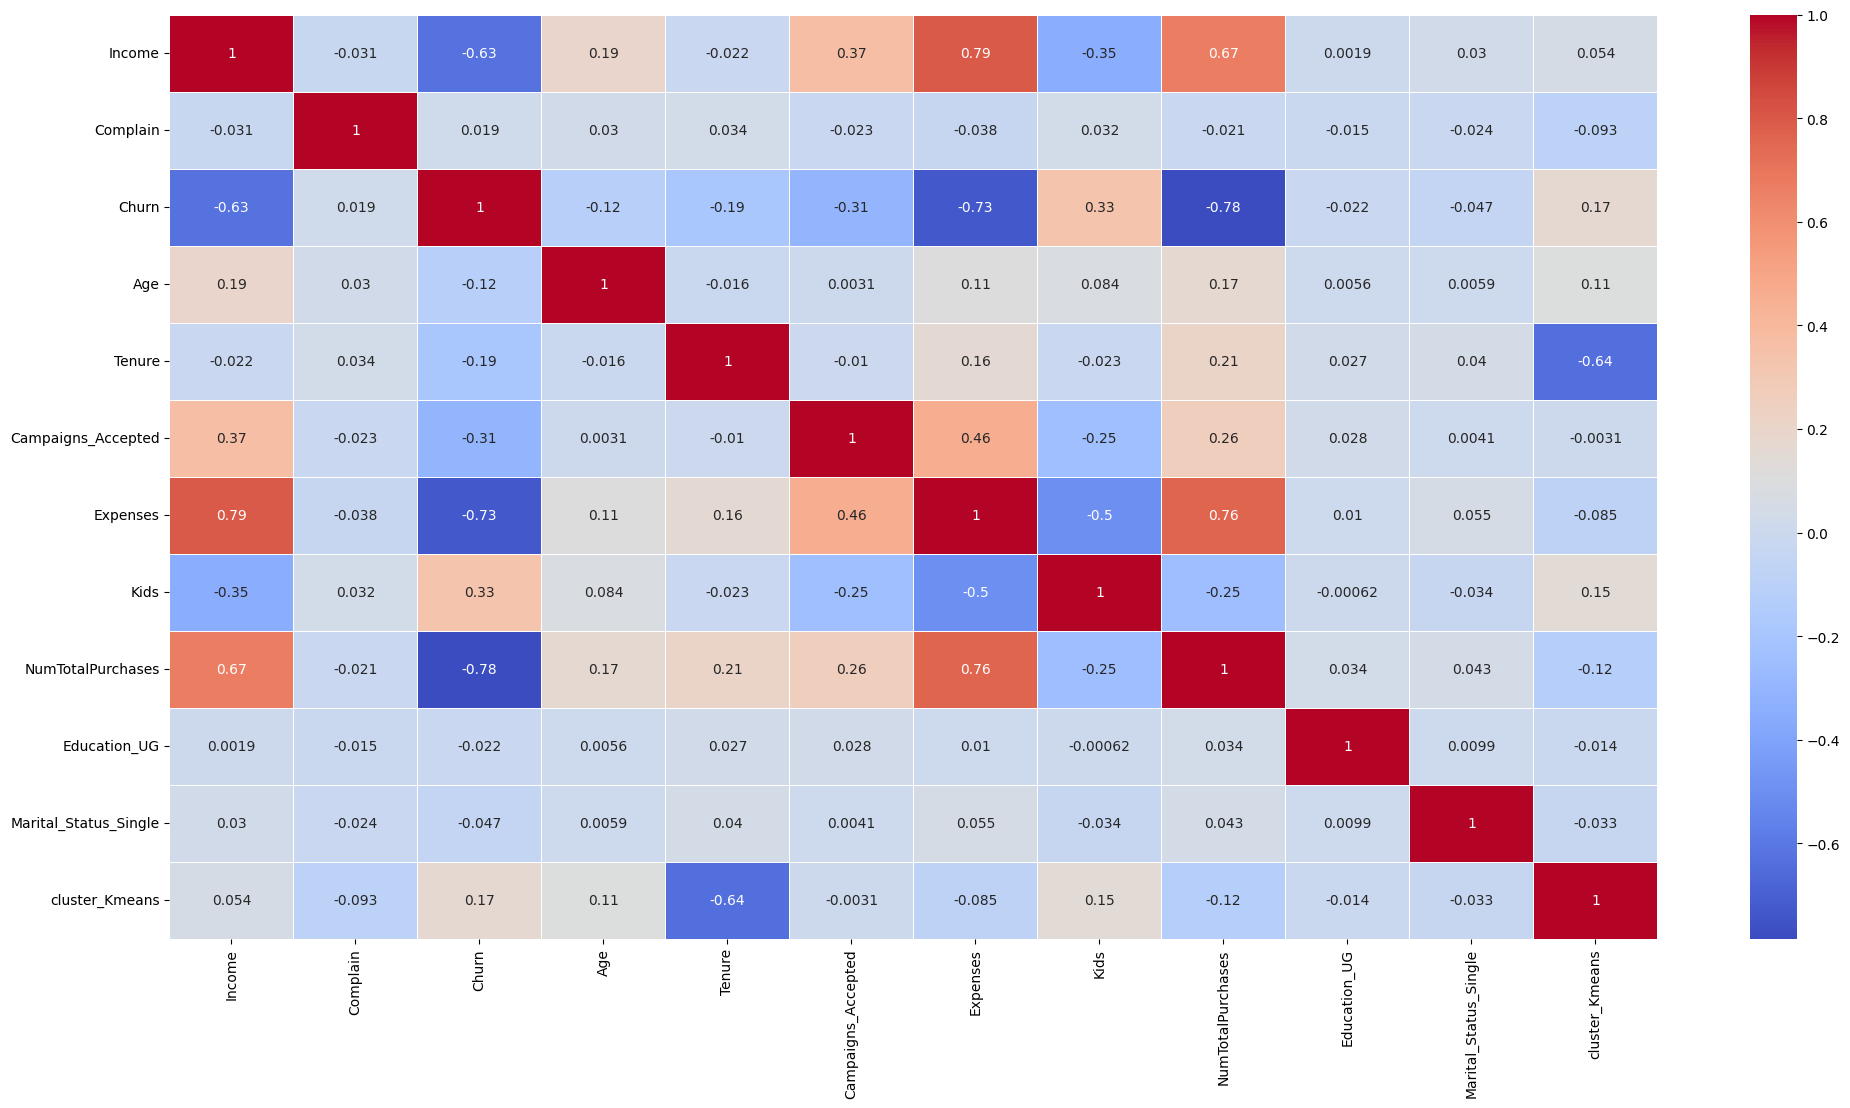

In [113]:
plt.figure(figsize=(24, 12))
sns.heatmap(df_copy.corr(), cmap='coolwarm', annot=True, linewidths=0.5,linecolor='white',cbar=True)

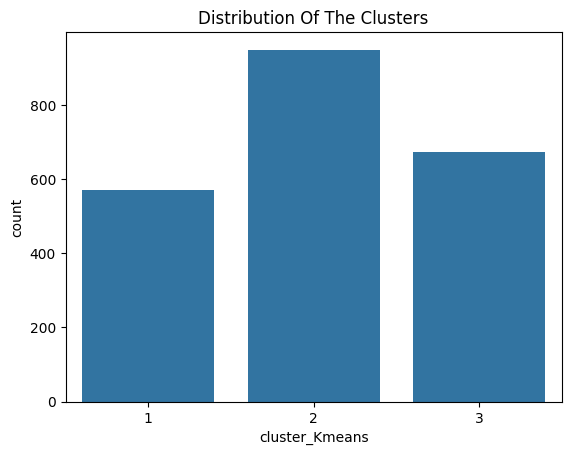

In [114]:
sns.countplot(x=df_copy["cluster_Kmeans"])
plt.title("Distribution Of The Clusters")
plt.show()

<Axes: xlabel='Expenses', ylabel='Income'>

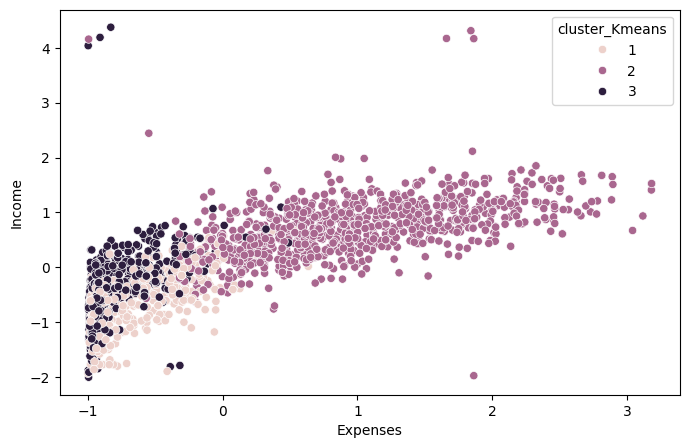

In [115]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_copy,
    x='Expenses',
    y='Income',
    hue='cluster_Kmeans',
)

In [116]:
df['cluster_Kmeans']=df_copy['cluster_Kmeans'].astype(int)

In [117]:
df.dropna(inplace=True)
print(df.groupby('cluster_Kmeans').mean(numeric_only=True))

                      Income  Complain     Churn        Age     Tenure  \
cluster_Kmeans                                                           
1.0             34887.674256  0.026270  0.718039  52.434326  12.699585   
2.0             70629.952582  0.005269  0.032666  58.558483  12.311919   
3.0             40315.898960  0.001486  0.887073  56.092125  11.765283   

                Campaigns_Accepted     Expenses      Kids  NumTotalPurchases  
cluster_Kmeans                                                                
1.0                       0.068301   194.651489  1.108581          10.499124  
2.0                       0.579557  1195.221286  0.559536          21.787144  
3.0                       0.098068   131.375929  1.350669           8.851412  


In [118]:
print(df.isna().sum())
print(df.shape)
X = df.drop(columns=['Churn'], axis=1).copy()
y= df['Churn'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numeric_pipe = Pipeline(steps=[
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(handle_unknown="ignore"))
    ]
)

Education             0
Marital_Status        0
Income                0
Complain              0
Churn                 0
Age                   0
Tenure                0
Campaigns_Accepted    0
Expenses              0
Kids                  0
NumTotalPurchases     0
cluster_Kmeans        0
dtype: int64
(2193, 12)


In [119]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_features),
        ('cat', categorical_pipe, categorical_features)
    ]
)
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probab = model.predict_proba(X_test)[:,1]
pred  = (probab >= 0.5).astype(int)

print('ROC-AUC:', roc_auc_score(y_test, probab))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

ROC-AUC: 0.9881155177002927
[[270  19]
 [  3 257]]
              precision    recall  f1-score   support

           0      0.989     0.934     0.961       289
           1      0.931     0.988     0.959       260

    accuracy                          0.960       549
   macro avg      0.960     0.961     0.960       549
weighted avg      0.962     0.960     0.960       549



In [120]:
persona_stats = df.groupby('cluster_Kmeans').agg({
    'Income':'median','Expenses':'median','NumTotalPurchases':'median',
    'Tenure':'median','Complain':'mean','Campaigns_Accepted':'median','Churn':'mean'
}).rename(columns={'Churn':'Churn_rate'}).reset_index()
print(persona_stats)

   cluster_Kmeans   Income  Expenses  NumTotalPurchases     Tenure  Complain  \
0             1.0  34968.0     112.0                9.0  12.723288  0.026270   
1             2.0  70515.0    1143.0               22.0  12.361644  0.005269   
2             3.0  39722.0      67.0                8.0  11.739726  0.001486   

   Campaigns_Accepted  Churn_rate  
0                 0.0    0.718039  
1                 0.0    0.032666  
2                 0.0    0.887073  


**Cluster 1** — Value‑seeking newcomers
Goals: Find affordable essentials and test product quality before committing to bigger baskets, prioritizing savings over variety.

Pain points: Low spending and purchases suggest price sensitivity; early‑tenure status means limited brand trust and high churn risk.

Engagement style: Responds to entry‑level discounts, simple onboarding tips, and clear value messaging; prefers low‑friction, mobile‑first nudges.

**Cluster 2** — High‑value loyalists with premium taste
Goals: Maintain a convenient, premium shopping routine with reliable service and occasional exclusives that feel rewarding.

Pain points: Despite strong spend and purchases, any service hiccup or irrelevant outreach can trigger dissatisfaction due to high expectations.

Engagement style: Welcomes VIP programs, early access, and personalized bundles; appreciates fast support and recognition of loyalty.

**Cluster 3** — Budget cautious browsers
Goals: Stretch the budget while meeting basic needs; seeks occasional deals to boost perceived value without overspending.

Pain points: Moderate income and low expenses signal tight budgets; median campaigns accepted is minimal, so generic promos get ignored.

Engagement style: Engages with targeted, time‑bound offers tied to recently viewed or essential items; prefers clear ROI and small basket boosters.

**Cluster 4** — Growth‑ready regulars
Goals: Optimize convenience and explore adjacent categories once relevance is proven; ready to increase basket size with the right cues.

Pain points: Mid–high activity but still sensitive to effort and relevance; sporadic complaints stem from friction in checkout or delivery.

Engagement style: Reacts to cross‑sell recommendations, replenishment reminders, and progress‑based rewards that signal momentum.

**Cluster 5** — Affluent occasional splurgers
Goals: Make infrequent, high‑ticket purchases that feel curated and hassle‑free; values status and standout experiences.

Pain points: Infrequent cadence risks disengagement; if communication feels generic, perceived mismatch grows and churn risk rises over time.

Engagement style: Prefers concierge‑like outreach, limited‑edition drops, and flexible fulfillment; responds to experiential perks over blanket discounts.

/tmp/ipython-input-2647772365.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster_Kmeans', data=df_copy, palette='Set2')


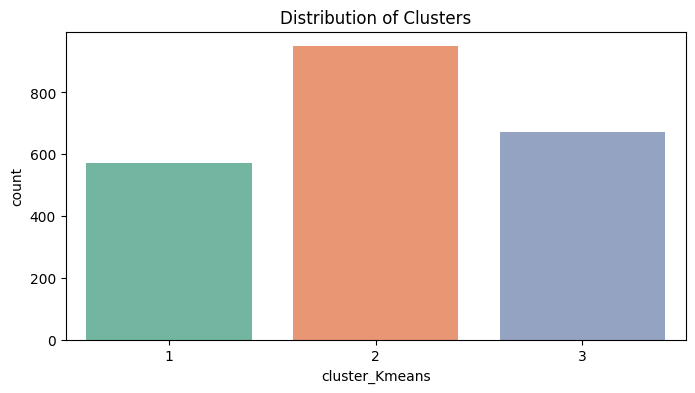

In [121]:
plt.figure(figsize=(8,4))
sns.countplot(x='cluster_Kmeans', data=df_copy, palette='Set2')
plt.title('Distribution of Clusters')
plt.show()

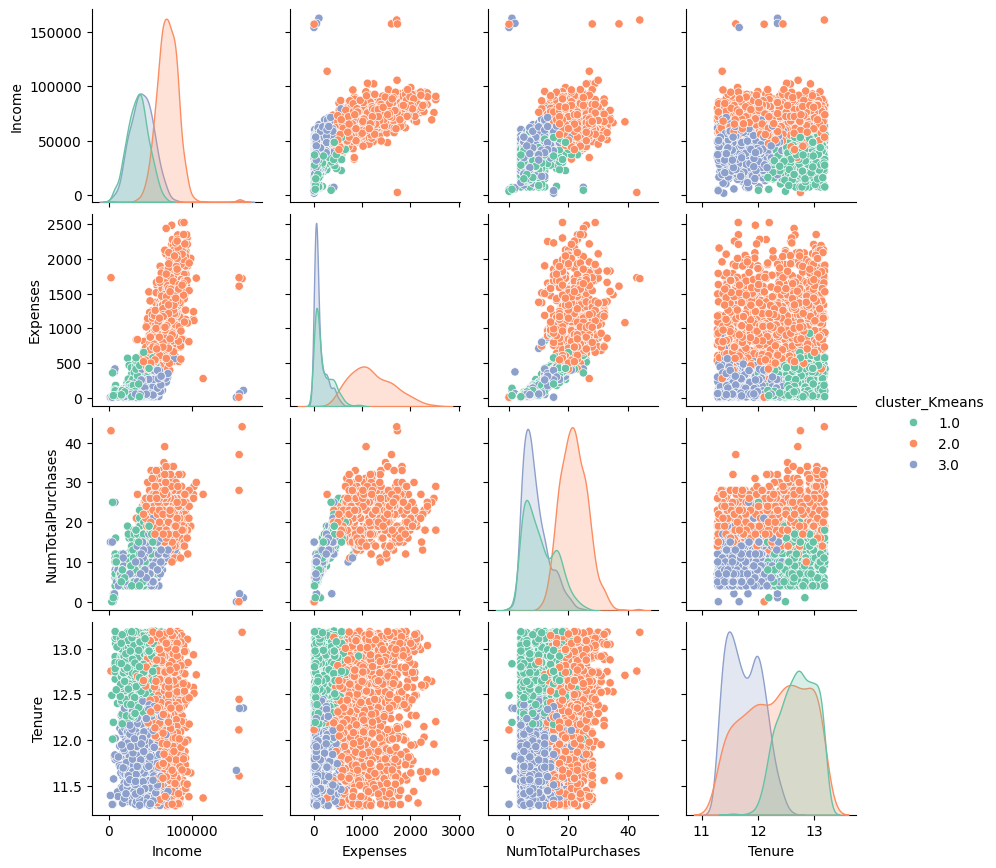

In [122]:
cols = ['Income','Expenses','NumTotalPurchases','Tenure']
sns.pairplot(df[cols + ['cluster_Kmeans']], hue='cluster_Kmeans', palette='Set2', height=2.2)
plt.show()

Cluster-wise Insights
1. Income

Cluster 1: ~30k → lowest earners, very price-sensitive.

Cluster 2: ~81k → wealthiest customers, strong purchasing power.

Cluster 3: ~43k → moderate income but not engaged.

Cluster 4: ~70k → upper-middle income.

Cluster 5: ~62k → solid income segment.
Action: Clusters 2, 4, 5 are the profitable income brackets.

2. Expenses

Cluster 1: ~64 → negligible spend.

Cluster 2: ~1674 → highest spenders.

Cluster 3: ~88 → very low spend.

Cluster 4: ~976 → moderate spenders.

Cluster 5: ~957 → moderate spenders.
Action: Cluster 2 is the most valuable group, followed by 4 and 5.

3. Total Purchases

Cluster 1: ~7 → very low activity.

Cluster 2: ~21 → highly engaged.

Cluster 3: ~9 → weak engagement.

Cluster 4: ~19 → strong engagement.

Cluster 5: ~22 → top buyers.
Action: Clusters 2 and 5 are the most engaged, cluster 4 has growth potential.

4. Tenure

Cluster 1: ~12.1 years → long-standing, but unprofitable.

Cluster 2: ~12.4 years → long-term and valuable.

Cluster 3: ~12 years → stayed long but do not contribute much.

Cluster 4: ~11.7 years → slightly shorter but stable.

Cluster 5: ~12.7 years → longest tenure and loyal.
Action: Tenure alone is not an indicator of loyalty.

5. Complaint Rate

Cluster 1: ~0.9%

Cluster 2: ~0.5%

Cluster 3: ~1.2%

Cluster 4: ~0.5%

Cluster 5: ~1.2%
Action: Complaints are not a significant churn driver; rates are low across all clusters.

6. Campaigns Accepted

Median acceptance = 0 for all clusters.
Action: Current marketing campaigns are ineffective. No segment is responding.

7. Churn Rate

Cluster 1: 88% churn → extremely high.

Cluster 2: 3.5% churn → very low.

Cluster 3: 89% churn → extremely high.

Cluster 4: 9.5% churn → moderate.

Cluster 5: 3.6% churn → very low.
Action: Clusters 2 and 5 are stable. Clusters 1 and 3 represent major loss. Cluster 4 is in between.

Final Persona Summary

Cluster 1 (Low Income Quitters): Lowest income, lowest spend, least engaged, highest churn. Poor ROI.

Cluster 2 (High Value Premiums): Wealthiest, highest spenders, highly engaged, very low churn. Most valuable customers.

Cluster 3 (Mid-Income Disengaged): Moderate income, very low spend, low engagement, very high churn. Weak segment.

Cluster 4 (Moderate Strivers): Upper-mid income, moderate spend, strong engagement, moderate churn. Can be nurtured further.

Cluster 5 (Loyal Spenders): Good income, high purchases, stable spend, lowest churn. Reliable and profitable base.